In [24]:
import sys
sys.path.append('../utils')
sys.path.append('../core')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
from core import *

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob

In [25]:
test_phantom = phantom.Phantom(source_path = None,
            voxel_dims = (0.5e-3,0.5e-3,0.5e-3),
            matrix_dims = (100,100,100),
            baseline = (1500, 1000),
            seed = 5678,)

blood = tissue.Tissue(name='blood', c=1578, rho=1060, sigma=5.3, scale=0.00001, label=1)
myocardium = tissue.Tissue(name='myocardium', c=1561.3, rho=1081, sigma=50, scale=0.0001, label=2)
fat = tissue.Tissue(name='fat', c=1450, rho=920, sigma=0, scale=1, label=3)

pos = 0.01

test_phantom.add_tissue(fat, mask=np.ones(test_phantom.matrix_dims))
test_phantom.add_tissue_sphere((pos,0,0), 4, myocardium)
test_phantom.add_tissue_sphere((0,pos,0), 4, myocardium)
test_phantom.set_default_tissue('fat')
test = test_phantom.get_complete()

514


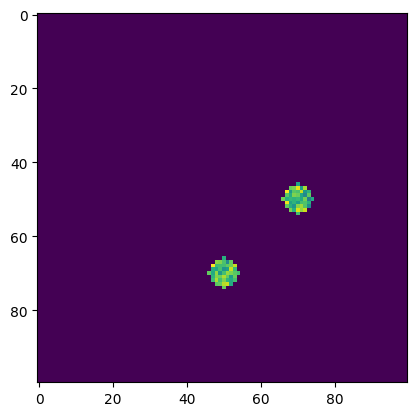

In [26]:
plt.imshow(test[0,:,:,test_phantom.matrix_dims[2]//2])
x = test_phantom.mask
print(np.sum(np.where(x != 3, 1, 0)))


In [27]:
# transducers = [transducer.Planewave(max_frequency=0.5e6,
#                                     elements = 64, 
#                                     width = 40e-3,
#                                     height =  20e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/6,
#                                     ray_num = 16, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 20e-3,
#                                     ) for i in range(1)]

transducers = [transducer.Focused(max_frequency=0.5e6,
                                    elements = 64, 
                                    width = 20e-3,
                                    height =  20e-3,
                                    sensor_sampling_scheme = 'not_centroid', 
                                    sweep = np.pi/4,
                                    ray_num = 16, 
                                    imaging_ndims = 2,
                                    focus_elevation = 15e-3,
                                    focus_azimuth = 15e-3,
                                    ) for i in range(3)]

for t in transducers:
    t.make_sensor_coords(test_phantom.baseline[0])

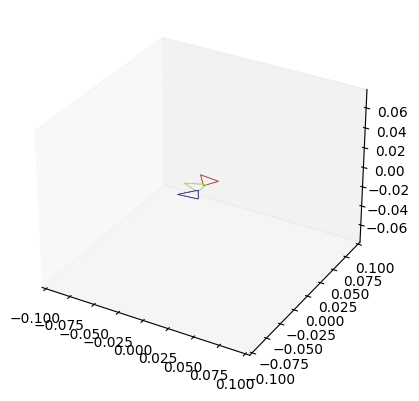

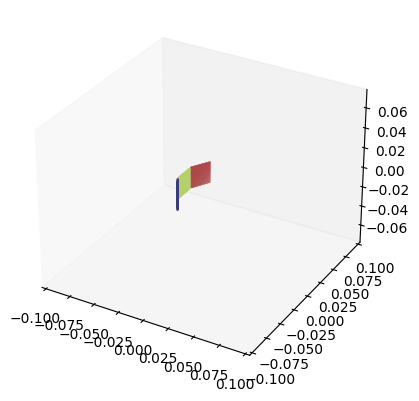

In [43]:
test_transducer_set = transducer_set.TransducerSet(transducers, seed=8888)
#test_transducer_set.generate_extrinsics(shape="spherical", extrinsics_kwargs={'r_mean': 1e-3, 'view_std': 0, 'yaw_fraction': 1, 'pitch_fraction': 0, 'roll_fraction': 0})
# test_transducer_set.assign_pose(0, geometry.Transform([-np.pi/6,0,0], [0,0.01,0]))
# test_transducer_set.assign_pose(1, geometry.Transform([np.pi/6,0,0], [0,-0.01,0]))
# test_transducer_set.assign_pose(0, geometry.Transform([-np.pi/20,0,0], [0,0.01,0]))
# test_transducer_set.assign_pose(1, geometry.Transform([np.pi/20,0,0], [0,-0.01,0]))

test_transducer_set.assign_pose(0, geometry.Transform([np.pi/6,0,0], [-0.015,-0.02,0]))
test_transducer_set.assign_pose(1, geometry.Transform([0,0,0], [-0.02, 0,0]))
test_transducer_set.assign_pose(2, geometry.Transform([-np.pi/6,0,0], [-0.015,0.02,0]))
test_transducer_set.plot_transducer_fovs(scale=0.1)
test_transducer_set.plot_transducer_coords(scale=0.1)

In [44]:
# test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='pressure_field')
test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='extended_aperture')
# test_sensor = sensor.Sensor(transducer_set=test_transducer_set, aperture_type='transmit_as_receive')

In [45]:
simprops = simulation.SimProperties(
                grid_size   = (50e-3,50e-3,30e-3),
                voxel_size  = (0.5e-3,0.5e-3,0.5e-3),
                PML_size    = (32,8,8),
                PML_alpha   = 2,
                t_end       = 12e-5,           # [s]
                bona        = 6,               # parameter b/a determining degree of nonlinear acoustic effects
                alpha_coeff = 0.5, 	           # [dB/(MHz^y cm)]
                alpha_power = 1.5,
                )

In [46]:
test_experiment = experiment.Experiment(
                 simulation_path = '../experiment_files/planewave_test_03',
                 sim_properties  = simprops,
                 phantom         = test_phantom,
                 transducer_set  = test_transducer_set,
                 sensor          = test_sensor,
                 nodes           = 1,
                 results         = None,
                 indices         = None,
                 workers         = 1,
                 additional_keys = []
                 )

test_experiment.save()

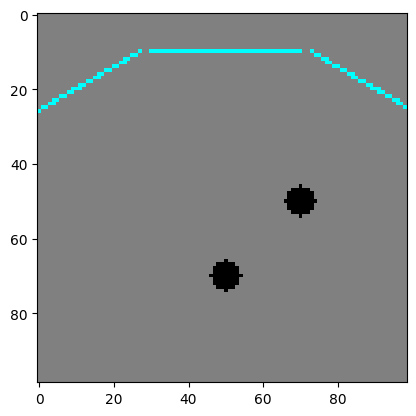

In [47]:
test_experiment.visualize_sensor_mask(index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])

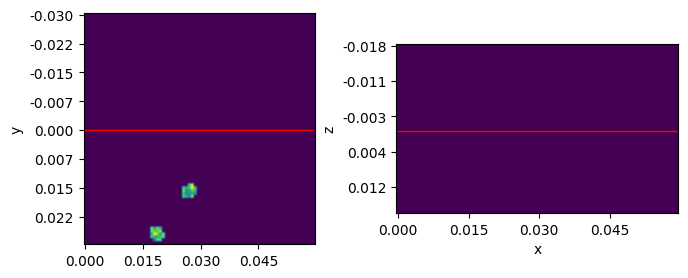

In [48]:
test_experiment.plot_ray_path(0)

In [49]:
test_experiment = experiment.Experiment.load('../experiment_files/planewave_test_03')
test_experiment.run(dry=True)

Number of simulation results (16) is less than the expected number of simulation results (48), are you sure the simulation finished running?
dry run of simulation


100%|██████████| 3/3 [00:00<00:00, 13.88it/s]


In [50]:
test_experiment.run(repeat=True)

running with 1 workers

preparation for sim    0 completed in  0.58 seconds
preparation for sim    1 completed in  0.61 seconds
preparation for sim    2 completed in  0.58 seconds
simulation             0 completed in  1.31 seconds
preparation for sim    3 completed in  0.60 seconds
preparation for sim    4 completed in  0.60 seconds
preparation for sim    5 completed in  0.66 seconds
simulation             1 completed in  1.48 seconds
simulation             2 completed in  1.11 seconds
simulation             3 completed in  1.12 seconds
simulation             4 completed in  1.11 seconds
simulation             5 completed in  1.11 seconds
preparation for sim    6 completed in  0.56 seconds
preparation for sim    7 completed in  0.60 seconds
preparation for sim    8 completed in  0.64 seconds
simulation             6 completed in  1.43 seconds
preparation for sim    9 completed in  0.58 seconds
preparation for sim   10 completed in  0.57 seconds
preparation for sim   11 completed in  0

In [13]:
test_experiment.add_results()

In [14]:
test_reconstruction = reconstruction.Compounding(experiment=test_experiment)

In [15]:
pfield = utils.load_array('1mhz_pfield.npz')

In [16]:
image_matrices = test_reconstruction.compound(workers=16, resolution_multiplier=4, local=True, combine=False, pressure_field=None)

100%|██████████| 16/16 [00:00<00:00, 294337.12it/s]


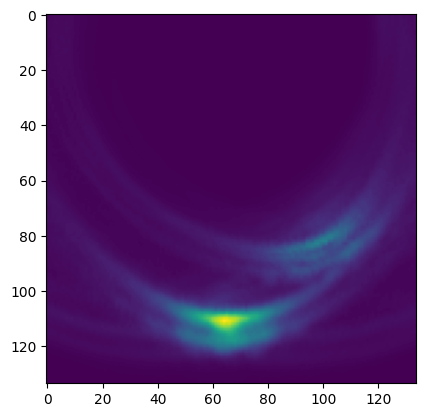

In [17]:
image = np.sum(image_matrices, axis=0)
plt.imshow(image[:,:,image.shape[2]//2])

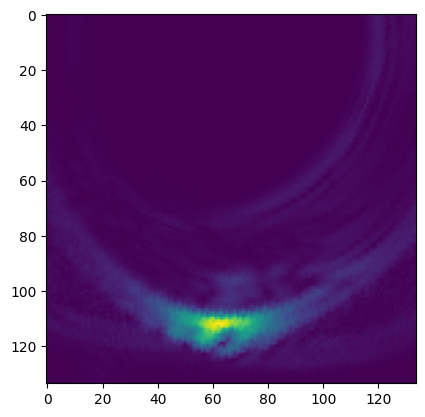

In [18]:
plt.imshow(image_matrices[0][:,:,image_matrices[0].shape[2]//2])

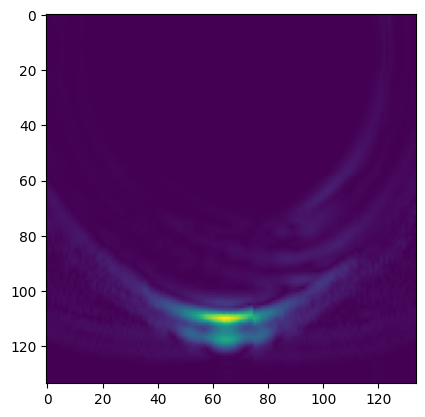

In [19]:
plt.imshow(image_matrices[7][:,:,image_matrices[7].shape[2]//2])

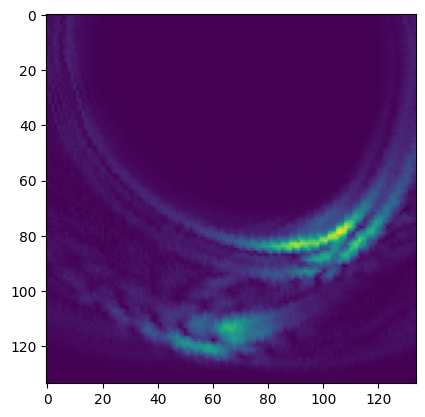

In [20]:
plt.imshow(image_matrices[-3][:,:,image_matrices[-3].shape[2]//2])

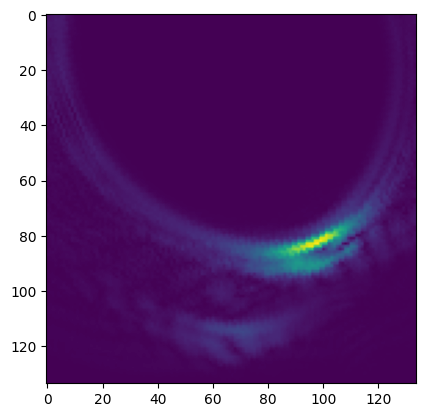

In [21]:
plt.imshow(image_matrices[-1][:,:,image_matrices[-1].shape[2]//2])

In [22]:
plt.imshow(image_matrices[:,:,image_matrices.shape[2]//2])
# plt.imshow(image[:,:,image.shape[2]//2])

AttributeError: 'list' object has no attribute 'shape'

In [ ]:
from scipy.signal import hilbert2

In [ ]:
local_image_matrix = np.abs(hilbert2(image[:,:,image.shape[2]//2]))

In [ ]:
plt.imshow(local_image_matrix)

In [ ]:
assert False

In [ ]:
plt.imshow(image[:,:,image.shape[2]//2])

In [ ]:
plt.imshow(image[:,:,image.shape[2]//2])

In [ ]:
gm = test_experiment.sensor.visualize(test_phantom, index=[slice(0, -1, 1), slice(0, -1, 1), test_phantom.matrix_dims[2]//2])